In [1]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
%matplotlib inline
pyro.set_rng_seed(42)

In [2]:
# race
df = pd.read_csv('model2_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )
print(race_alias)
race_prob

['African-American', 'Caucasian']


tensor([0.5999, 0.4001])

In [3]:
# sex
df = pd.read_csv('model2_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )
print(sex_alias)
sex_prob

['Female', 'Male']


tensor([0.1992, 0.8008])

In [4]:
# age_cat
df = pd.read_csv('model2_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )
print(age_cat_alias)
age_cat_prob

['25 - 45', 'Greater than 45', 'Less than 25']


tensor([0.5701, 0.2182, 0.2117])

In [5]:
# c_charge_degree
df = pd.read_csv('model2_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

print(c_charge_degree_alias)
c_charge_degree_probs

['M', 'F']


tensor([[[[0.3671, 0.6329],
          [0.2727, 0.7273],
          [0.3512, 0.6488]],

         [[0.3213, 0.6787],
          [0.3482, 0.6518],
          [0.2278, 0.7722]]],


        [[[0.4272, 0.5728],
          [0.5205, 0.4795],
          [0.4368, 0.5632]],

         [[0.3706, 0.6294],
          [0.4337, 0.5663],
          [0.3030, 0.6970]]]])

In [6]:
# two_year_recid
df = pd.read_csv('model2_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['c_charge_degree'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in c_charge_degree_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

print(two_year_recid_alias)
two_year_recid_probs

[0, 1]


tensor([[[0.5469, 0.4531],
         [0.4620, 0.5380]],

        [[0.6656, 0.3344],
         [0.5678, 0.4322]]])

In [7]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][c_charge_degree]))

### Intervention

In [8]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

(array([ 1.,  0.,  2., 14., 22., 24., 16., 12.,  6.,  3.]),
 array([-0.25 , -0.185, -0.12 , -0.055,  0.01 ,  0.075,  0.14 ,  0.205,
         0.27 ,  0.335,  0.4  ]),
 <a list of 10 Patch objects>)

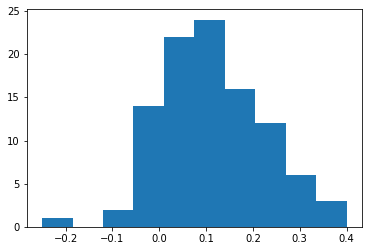

In [9]:
ls = []
for run in range(100):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]
plt.hist(ls) 

### Counterfactual fairness

In [10]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

(array([ 4.,  4., 18., 16., 13., 24., 14.,  5.,  1.,  1.]),
 array([0.4  , 0.424, 0.448, 0.472, 0.496, 0.52 , 0.544, 0.568, 0.592,
        0.616, 0.64 ]),
 <a list of 10 Patch objects>)

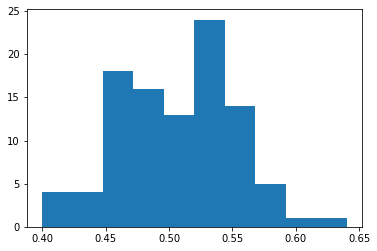

In [11]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in range(100):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]
plt.hist(ls) 